### Large Data Problem

If the size of the data is very large (large number of time series; each time series consisting of large number of samples), we face two types of challenges: 

- Large execution time (Compute bound problem)
- Need for larger memory (Memory bound problem)

#### Large Execution Time
If the data fits into main memory(RAM), `tsfresh` solves the large execution time problem, by utlizing
- **multiple processors in a single machine** (using `multiprocessing` package). This is the default option. Whenever, `tsfresh` package is used, multiprocessing is switched on by default. Number of processors/cores to be used can be cotrolled using `n_jobs` flag.
- **multiple processors spread across multiple machines** (Cluster/Distributed Computing). `tsfresh.utilities.distribution` module consists of various distributors including Dask based `tsfresh.utilities.distribution.ClusterDaskDistributor`. `ClusterDaskDistributor` distributes the job across various workers in a Dask cluster.

#### Need for larger memory
For data that doesn't fit into main memory (RAM), `tsfresh` utilizes `Dask` for out of core computation and for distributing the data across multiple machines in a cluster. `tsfresh` provides convenience function for this: `tsfresh.convenience.bindings.dask_feature_extraction_on_chunk`.

It's worth mentioning, `tsfresh` provides convenience function which addresses large data issue using **Apache Spark** as well (`tsfresh.convenience.bindings.spark_feature_extraction_on_chunk()`). However, this notebook focuses only on Dask.

In [1]:
import glob
import os
import sys

import pandas as pd
import numpy as np

import dask
from dask.distributed import Client
import dask.dataframe as dd

In [2]:
def get_segment_id_from_path(df, path):
    """
    Returns the segment_id from the path of the file 
    """
    df.segment_id = df.segment_id.str.replace(path, "")
    df.segment_id = df.segment_id.str.replace(".csv", "")
    df.segment_id = df.segment_id.astype(np.int64)
    
    return df

def append_time_column(df):
    df["time"] = range(0, len(df))
    
    return df

In [3]:
DATA_DIR = "/opt/vssexclude/personal/kaggle/volcano/data/raw/train"

# Define the datatypes for different sensor data
data_types = {"sensor_1" : np.float32, 
                 "sensor_2" : np.float32, 
                 "sensor_3" : np.float32,
                 "sensor_4" : np.float32,
                 "sensor_5" : np.float32,
                 "sensor_6" : np.float32,
                 "sensor_7" : np.float32,
                 "sensor_8" : np.float32,
                 "sensor_9" : np.float32,
                 "sensor_10" : np.float32}

### Start Dask Client

<img src="../images/dask_architechture_diagram.png" width="600" height="200" style="border-style: solid;">

In [4]:
client = Client(n_workers=10, threads_per_worker=1, memory_limit='2GB')

In [5]:
client

Client Scheduler: tcp://127.0.0.1:42041 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 10 Cores: 10 Memory: 20.00 GB


### Read Data

## ClusterDaskDistributor

When data fits into memory, but we need to distribute the feature engineering job across the cluster.

- Data is loaded using Pandas DataFrame, i.e. entire data is loaded into RAM
- Extracted features is also a Pandas DataFrame

In [6]:
df = pd.DataFrame()
for name in glob.glob(f"{DATA_DIR}/140*"):
    temp_df = pd.read_csv(name, dtype=data_types, nrows=1000)
    
    # Extract name of the segment from the file name
    segment_id = int(name.split(".")[0].split("/")[-1])
    temp_df["segment_id"] = segment_id
    print(f"Reading data for segment: {segment_id}")
    
    # Create a column named time
    temp_df["time"] = range(0, len(temp_df))
    
    df = df.append(temp_df)
    
print("\n")    
print(f"Shape of the dataframe consisting of all data from above files: {df.shape}")

Reading data for segment: 1407094442
Reading data for segment: 1405189645
Reading data for segment: 1403440092
Reading data for segment: 1405443107
Reading data for segment: 1400929225
Reading data for segment: 1400727315
Reading data for segment: 1403947680
Reading data for segment: 1400253000
Reading data for segment: 140031872
Reading data for segment: 1409167039
Reading data for segment: 1408663387
Reading data for segment: 1406456924
Reading data for segment: 1404179874
Reading data for segment: 1403005697
Reading data for segment: 1408645616
Reading data for segment: 140851065
Reading data for segment: 140348256
Reading data for segment: 1407261706
Reading data for segment: 1404122310
Reading data for segment: 1404322654
Reading data for segment: 1406938061
Reading data for segment: 1403222059
Reading data for segment: 1402674973
Reading data for segment: 1408285202
Reading data for segment: 1404502479
Reading data for segment: 1402556914
Reading data for segment: 1406626451
Read

In [7]:
df  = df.loc[:, ["segment_id", "time", "sensor_1", "sensor_4"]]
df.head()

,segment_id,time,sensor_1,sensor_4
0,1407094442,0,-580.0,-458.0
1,1407094442,1,-598.0,-432.0
2,1407094442,2,-615.0,-342.0
3,1407094442,3,-592.0,-204.0
4,1407094442,4,-536.0,-14.0


In [9]:
from tsfresh.utilities.distribution import ClusterDaskDistributor

dask_distributor = ClusterDaskDistributor(address="127.0.0.1:42041")

In [10]:
from tsfresh.feature_extraction import extract_features
from tsfresh.feature_extraction.settings import MinimalFCParameters
from tsfresh.feature_extraction.settings import EfficientFCParameters
from tsfresh.feature_extraction.settings import ComprehensiveFCParameters

extracted_features = extract_features(timeseries_container=df,
                     column_id='segment_id', column_sort='time',
                     default_fc_parameters=ComprehensiveFCParameters(),
                     distributor=dask_distributor)

In [11]:
dask_distributor.close()

In [12]:
extracted_features.head()

,sensor_1__variance_larger_than_standard_deviation,sensor_1__has_duplicate_max,sensor_1__has_duplicate_min,sensor_1__has_duplicate,sensor_1__sum_values,sensor_1__abs_energy,sensor_1__mean_abs_change,sensor_1__mean_change,sensor_1__mean_second_derivative_central,sensor_1__median,...,sensor_4__fourier_entropy__bins_2,sensor_4__fourier_entropy__bins_3,sensor_4__fourier_entropy__bins_5,sensor_4__fourier_entropy__bins_10,sensor_4__fourier_entropy__bins_100,sensor_4__permutation_entropy__dimension_3__tau_1,sensor_4__permutation_entropy__dimension_4__tau_1,sensor_4__permutation_entropy__dimension_5__tau_1,sensor_4__permutation_entropy__dimension_6__tau_1,sensor_4__permutation_entropy__dimension_7__tau_1
140031872,1.0,0.0,0.0,1.0,-54490.0,4.788279e+07,25.139139,0.024024,-0.001503,-43.0,...,0.079983,0.217718,0.376590,0.604455,1.128716,1.282814,1.941725,2.624954,3.290594,3.948798
140348256,1.0,0.0,0.0,1.0,-12608.0,6.405095e+07,26.994995,-0.346346,-0.014028,4.5,...,0.188113,0.341424,0.500208,0.651610,1.306434,1.511587,2.467225,3.460273,4.373737,5.122356
140851065,1.0,1.0,0.0,1.0,-3568.0,3.067866e+08,61.619621,-1.369369,0.037074,11.0,...,0.110453,0.220352,0.249958,0.446547,0.804609,1.065453,1.467375,1.898141,2.319963,2.742632
1400253000,1.0,0.0,0.0,1.0,-5286.0,1.373399e+08,42.240242,-0.014014,0.055611,19.0,...,0.138228,0.138228,0.235155,0.325140,1.109209,1.414590,2.238319,3.114445,3.982191,4.805546
1400727315,1.0,1.0,1.0,1.0,354441.0,1.440664e+11,954.457458,10.207207,-0.476954,976.5,...,0.110453,0.125256,0.245901,0.325140,0.642095,0.994445,1.309224,1.640863,2.002486,2.372683


In [13]:
del df, dask_distributor

### spark_feature_extraction_on_chunk

This is applicable when the size of the data is large enough to fit into the main memory (RAM).

- Input Data to `tsfresh` is a Dask DataFrame. Dask utilizes out of core computing and hence Data is loaded into RAM partition by partition.
- Output Data (Extracted features) is also a Dask Dataframe. As a result data is loaded into RAM only when `compute()` is invoked.

In [14]:
%%time
ddf = dd.read_csv(
    urlpath=f"{DATA_DIR}/1408*.csv", 
    blocksize=None, 
    dtype=data_types,
    include_path_column='segment_id')

# Insert a new column with segment_id along with the values from 10 sensors
ddf = ddf.map_partitions(get_segment_id_from_path, f"{DATA_DIR}/")

# Add a column named time with ascending values staring from 0 representing time
ddf = ddf.map_partitions(append_time_column)

ddf = ddf.loc[0:999, :]

CPU times: user 70.6 ms, sys: 21.2 ms, total: 91.8 ms
Wall time: 101 ms


In [15]:
ddf.head()

,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10,segment_id,time
0,664.0,-1365.0,165.0,-176.0,191.0,128.0,-184.0,389.0,-40.0,-508.0,1408285202,0
1,659.0,-1650.0,201.0,-188.0,180.0,198.0,-391.0,360.0,-100.0,-551.0,1408285202,1
2,648.0,-1278.0,277.0,-199.0,433.0,200.0,-504.0,352.0,-141.0,-559.0,1408285202,2
3,613.0,-1180.0,318.0,-205.0,440.0,62.0,-394.0,297.0,-190.0,-520.0,1408285202,3
4,575.0,-718.0,329.0,-207.0,235.0,250.0,-186.0,12.0,-251.0,-467.0,1408285202,4


In [16]:
ddf = ddf.melt(id_vars=["segment_id", "time"],  
               value_vars=['sensor_1', 'sensor_4'],  
               var_name="sensor_type", 
               value_name="sensor_value")

In [17]:
ddf.head()

,segment_id,time,sensor_type,sensor_value
0,1408285202,0,sensor_1,664.0
1,1408285202,1,sensor_1,659.0
2,1408285202,2,sensor_1,648.0
3,1408285202,3,sensor_1,613.0
4,1408285202,4,sensor_1,575.0


In [18]:
ddf.tail()

,segment_id,time,sensor_type,sensor_value
1995,1408663387,995,sensor_4,-804.0
1996,1408663387,996,sensor_4,-1096.0
1997,1408663387,997,sensor_4,-1293.0
1998,1408663387,998,sensor_4,-1295.0
1999,1408663387,999,sensor_4,-1180.0


In [19]:
ddf.segment_id.value_counts().compute()

1408663387    2000
1408645616    2000
1408285202    2000
140851065     2000
Name: segment_id, dtype: int64

In [20]:
ddf.sensor_type.value_counts().compute()

sensor_4    4000
sensor_1    4000
Name: sensor_type, dtype: int64

In [23]:
ddf_grouped = ddf.groupby(["segment_id", "sensor_type"])

In [24]:
from tsfresh.convenience.bindings import dask_feature_extraction_on_chunk

from tsfresh.feature_extraction.settings import MinimalFCParameters

features = dask_feature_extraction_on_chunk(ddf_grouped, 
                                            column_id="segment_id", 
                                            column_kind="sensor_type", 
                                            column_value="sensor_value", 
                                            default_fc_parameters=MinimalFCParameters())

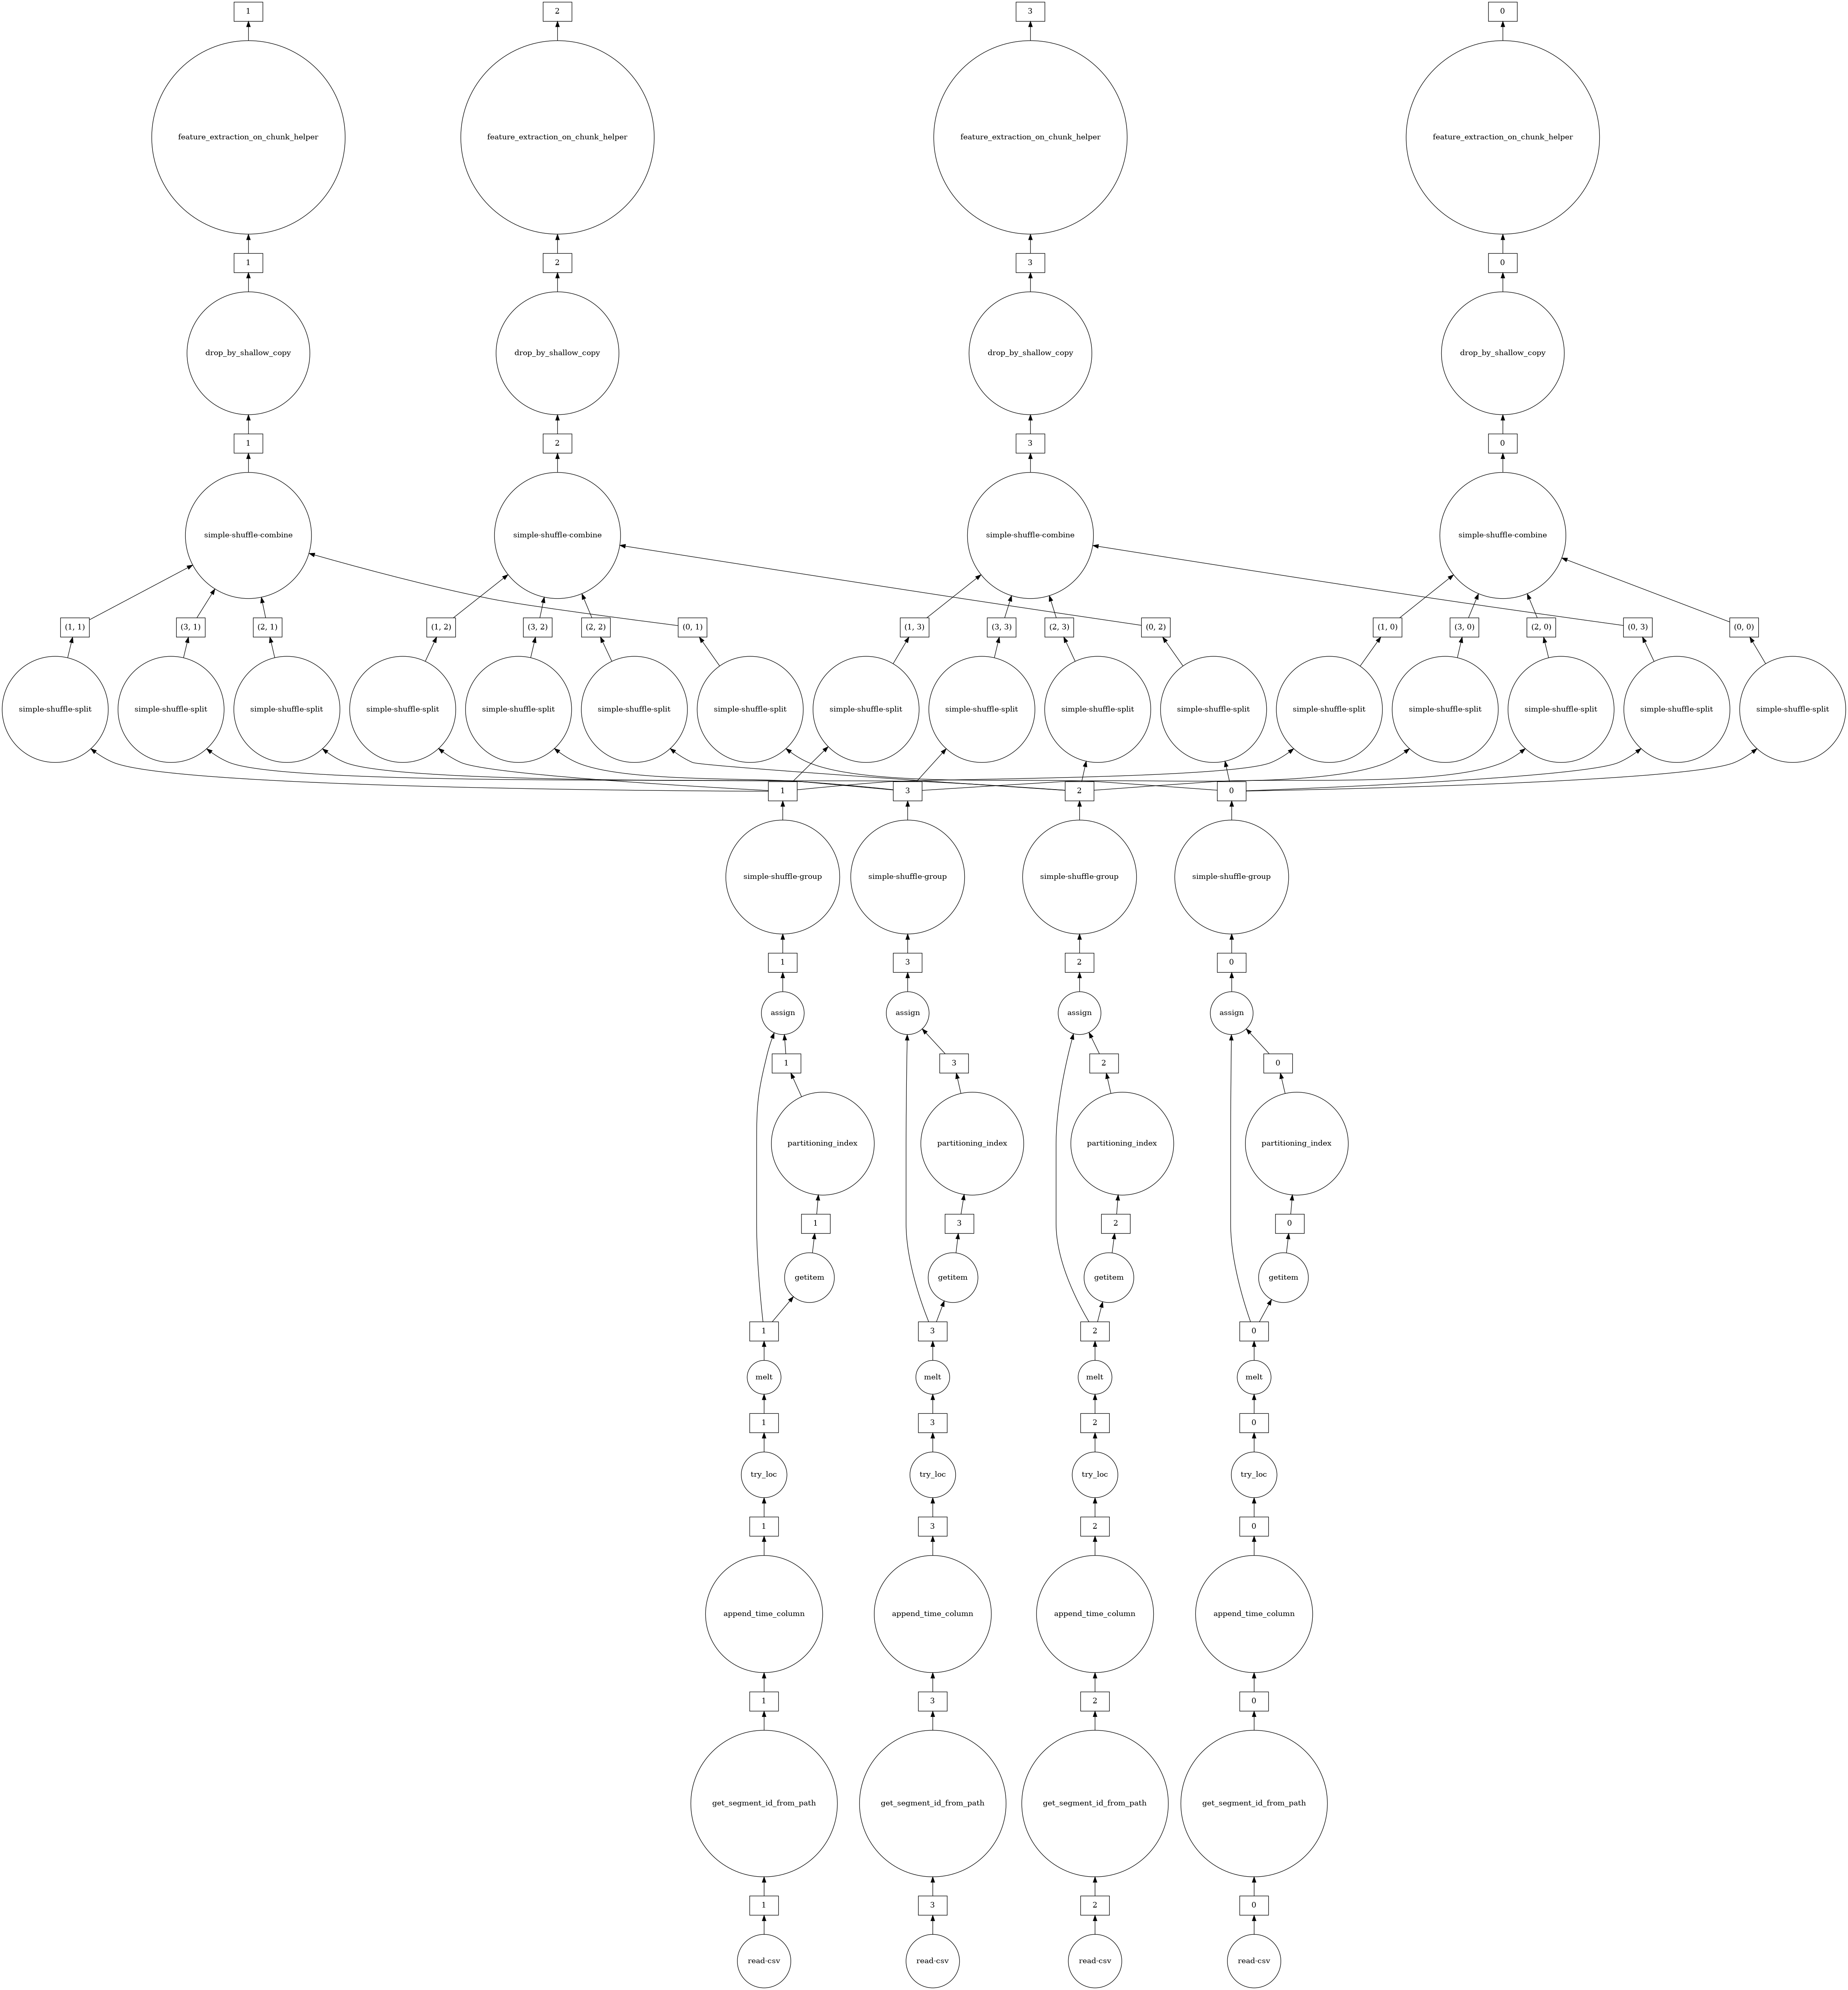

In [25]:
features.visualize()

In [26]:
features.head()

segment_id                      variable  \
segment_id sensor_type                                               
140851065  sensor_1    0   140851065          sensor_1__sum_values   
                       1   140851065              sensor_1__median   
                       2   140851065                sensor_1__mean   
                       3   140851065              sensor_1__length   
                       4   140851065  sensor_1__standard_deviation   

                                value  
segment_id sensor_type                 
140851065  sensor_1    0 -3568.000000  
                       1    11.000000  
                       2    -3.568000  
                       3  1000.000000  
                       4   553.871704

In [27]:
features = features.categorize(columns=["variable"])
features = features.reset_index(drop=True)


feature_table = features.pivot_table(index="segment_id",
                                     columns="variable",
                                     values="value",
                                     aggfunc="sum")

In [28]:
df_features = feature_table.compute()

In [29]:
df_features

variable,sensor_1__sum_values,sensor_1__median,sensor_1__mean,sensor_1__length,sensor_1__standard_deviation,sensor_1__variance,sensor_1__maximum,sensor_1__minimum,sensor_4__sum_values,sensor_4__median,sensor_4__mean,sensor_4__length,sensor_4__standard_deviation,sensor_4__variance,sensor_4__maximum,sensor_4__minimum
segment_id,,,,,,,,,,,,,,,,
140851065,-3568.0,11.0,-3.568000,1000.0,553.871704,306773.875000,1362.0,-1421.0,15264.0,-11.5,15.264,1000.0,840.077515,705730.187500,2239.0,-2409.0
1408285202,-22072.0,-15.5,-22.072001,1000.0,489.836029,239939.343750,1542.0,-1149.0,750.0,-16.5,0.750,1000.0,284.342224,80850.492188,709.0,-748.0
1408645616,3632.0,16.5,3.632000,1000.0,146.018661,21321.449219,387.0,-393.0,7376.0,9.0,7.376,1000.0,156.149536,24382.679688,403.0,-402.0
1408663387,-27061.0,-1.5,-27.061001,1000.0,878.037537,770949.875000,2869.0,-3776.0,5966.0,40.0,5.966,1000.0,401.826263,161464.343750,1162.0,-1295.0


In [30]:
df_features.columns

CategoricalIndex(['sensor_1__sum_values', 'sensor_1__median', 'sensor_1__mean',
                  'sensor_1__length', 'sensor_1__standard_deviation',
                  'sensor_1__variance', 'sensor_1__maximum',
                  'sensor_1__minimum', 'sensor_4__sum_values',
                  'sensor_4__median', 'sensor_4__mean', 'sensor_4__length',
                  'sensor_4__standard_deviation', 'sensor_4__variance',
                  'sensor_4__maximum', 'sensor_4__minimum'],
                 categories=['sensor_1__sum_values', 'sensor_1__median', 'sensor_1__mean', 'sensor_1__length', 'sensor_1__standard_deviation', 'sensor_1__variance', 'sensor_1__maximum', 'sensor_1__minimum', ...], ordered=False, name='variable', dtype='category')